<a href="https://colab.research.google.com/github/abidlifiras/llm-qcm-demo/blob/master/CamemBERT(Zero_shot_evalution_%2B_finetuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One-shot Evaluation of CamemBERT on Multi-label Multiple Choice QA Task

In [1]:
!git clone https://github.com/abidlifiras/llm-qcm-demo.git

Cloning into 'llm-qcm-demo'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 36 (delta 10), reused 24 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 698.93 KiB | 765.00 KiB/s, done.
Resolving deltas: 100% (10/10), done.


In [3]:
# Install required libraries
!pip install transformers==4.17 scikit-learn numpy==1.26.4 --quiet
!pip uninstall -y sentence-transformers thinc

In [4]:
import transformers
print(transformers.__version__)

4.17.0


In [26]:
# Import dependencies
import json
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import shutil
os.environ["WANDB_DISABLED"] = "true"

In [2]:
# Load test dataset
# The dataset contain 'question', 'answers' (dict with keys a-e), and 'correct_answers' (list of correct labels)
df_test = pd.read_json("llm-qcm-demo/dataset/test.json")
df_test.head()

,id,question,answers,correct_answers,subject_name,nbr_correct_answers
0,5987fa6bffd499eb439c90679d7fbca822d62bc639d1b9...,"Parmi les propositions suivantes, indiquer cel...","{'a': 'Le suc gastrique', 'b': 'La bile vésicu...",[c],pharmacie,1
1,6e87c8575bb9327470a27b7b51f7ea797802157bf3b0e9...,"Parmi les propositions suivantes, quelle est c...","{'a': 'Le pH reste constant', 'b': 'Le pH dimi...",[b],pharmacie,1
2,e0e98b574405e9131352337b65e76ce9c8bee4837790d7...,"Parmi les propositions suivantes, concernant l...","{'a': 'C'est un antibiotique à large spectre',...",[c],pharmacie,1
3,b0fd1cbf8968b8c825e35f3f085fe176831b8ac4f4fa0d...,Une des molécules suivantes issues de l'activa...,"{'a': 'C3b', 'b': 'C3d', 'c': 'C1', 'd': 'Bb',...",[e],pharmacie,1
4,d0c3a802a9700495b419f9a2ce7b3c66f8def1a140d76c...,"Parmi les effets indésirables suivants, un seu...","{'a': 'Toux', 'b': 'Hypokaliémie', 'c': 'Dysgu...",[b],pharmacie,1


In [11]:
# Load pre-trained CamemBERT model with a classification head for 5 labels (a, b, c, d, e)
tokenizer_CamemBERT = AutoTokenizer.from_pretrained("camembert-base")
CamemBERT = AutoModelForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=5,
    problem_type="multi_label_classification"
)
CamemBERT.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification 

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [9]:
 # Convert correct answer letters into binary vector (e.g. ['a','d'] -> [1,0,0,1,0])
def label_to_vector(correct_answers):
    vec = [0] * 5
    for ans in correct_answers:
        if ans in ['a', 'b', 'c', 'd', 'e']:
            idx = ord(ans) - ord("a")  # Convert letter to index (a=0, b=1, ...)
            vec[idx] = 1
    return vec


In [10]:
# Prepare tokenized input strings and label vectors
questions, labels = [], []
for _, row in df_test.iterrows():
    try:
        q = row["question"]              # Extract question text
        answers = row["answers"]         # Dictionary of options: {'a': ..., 'b': ..., ...}
        corrects = row["correct_answers"]# List of correct letters: ['a', 'c']
        label_vec = label_to_vector(corrects)  # Convert to binary vector [1,0,1,0,0]

        # Combine question and all answers into a single input string
        merged = " ".join([f"{k.upper()}: {v}" for k, v in sorted(answers.items())])
        full_input = f"Question: {q} Answers: {merged}"

        # Save to lists for batch processing
        questions.append(full_input)
        labels.append(label_vec)
    except Exception as e:
        print(f"Error processing row: {e}")  # Skip problematic rows
        continue

In [12]:
# Inference step: predict in batches to avoid memory issues
all_preds, all_labels = [], []
batch_size = 4  # increase if memory allows

for i in range(0, len(questions), batch_size):
    try:
        # Get batch of inputs and labels
        batch_q = questions[i:i+batch_size]
        batch_l = labels[i:i+batch_size]

        # Tokenize input batch
        enc = tokenizer_CamemBERT(batch_q, truncation=True, padding=True, return_tensors="pt")

        # Convert label batch to tensor
        label_tensor = torch.tensor(batch_l).float()

        with torch.no_grad():  # Disable gradients for inference
            logits = CamemBERT(**enc).logits      # Raw outputs
            probs = torch.sigmoid(logits)         # Convert to probabilities via sigmoid
            preds = (probs > 0.5).int()           # Apply threshold (0.5) to get binary predictions

        # Store predictions and labels
        all_preds.append(preds)
        all_labels.append(label_tensor)

        # Free up memory
        del enc, logits, probs, preds, label_tensor
        gc.collect()
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"Batch error at index {i}: {e}")  # Skip batch if error occurs
        continue

In [13]:
# Evaluation metrics
if all_preds and all_labels:
    all_preds_tensor = torch.cat(all_preds, dim=0)
    all_labels_tensor = torch.cat(all_labels, dim=0)
    exact_match_acc = (all_preds_tensor == all_labels_tensor.int()).all(dim=1).sum().item() / len(all_labels_tensor)
    macro_f1 = f1_score(all_labels_tensor, all_preds_tensor, average="macro")
    print(f"\n✅ Zero-shot CamemBERT Results:")
    print(f"- Exact Match Accuracy: {exact_match_acc:.4f}")
    print(f"- Macro F1-Score: {macro_f1:.4f}")
else:
    print("⚠️ No predictions were successfully generated.")


✅ One-shot CamemBERT Results:
- Exact Match Accuracy: 0.0129
- Macro F1-Score: 0.3951


# ------------------------------------------------------------------
# 📌 Conclusion and Next Steps
# ------------------------------------------------------------------
# As expected, the model's performance is limited:
# - Exact Match Accuracy is low (~1.45%), meaning it rarely gets all answers correct.
# - Macro F1-Score is moderate (~39%), showing it partially recognizes some correct answers.
#
# 🔧 Improvement Proposal:
# To enhance results, we will fine-tune CamemBERT on the training set specific to this task.
# This will allow the model to learn domain-specific cues and improve its ability to select
# the correct answer combinations.

# The next step is to implement fine-tuning using the train.json dataset and re-evaluate the model.

In [15]:
# Load training and validation datasets
df_train = pd.read_json("llm-qcm-demo/dataset/train.json")
df_dev = pd.read_json("llm-qcm-demo/dataset/dev.json")

In [16]:
# Convert correct answers into binary vectors (multi-label format)
def label_to_vector(correct_answers):
    vec = [0] * 5
    for ans in correct_answers:
        if ans in ['a', 'b', 'c', 'd', 'e']:
            idx = ord(ans) - ord("a")
            vec[idx] = 1
    return vec


In [18]:
# Define a custom dataset class compatible with HuggingFace Trainer
class QADataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.encodings = []  # List to store tokenized inputs
        self.labels = []     # List to store corresponding label vectors

        # Iterate through each row in the DataFrame
        for _, row in dataframe.iterrows():
            try:
                q = row["question"]          # Extract the question text
                answers = row["answers"]     # Extract the dictionary of answer options (a to e)
                corrects = row["correct_answers"]  # List of correct answer keys (e.g., ['a', 'c'])

                # Convert correct answers to a binary vector like [1, 0, 1, 0, 0]
                label_vec = label_to_vector(corrects)

                # Format all answer options into a readable string: A: ... B: ...
                merged = " ".join([f"{k.upper()}: {v}" for k, v in sorted(answers.items())])

                # Concatenate question and answers into a single input string
                full_input = f"Question: {q} Answers: {merged}"

                # Tokenize the input string
                encoding = tokenizer(
                    full_input,
                    truncation=True,
                    padding='max_length',
                    max_length=256
                )

                # Store the tokenized input and its corresponding label
                self.encodings.append(encoding)
                self.labels.append(label_vec)

            except:
                # Skip the row silently if any error occurs (e.g., malformed entry)
                continue

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.labels)

    def __getitem__(self, idx):
        # Format the tokenized input and label for one sample
        # tokenizer.pad() is used outside to return all necessary input fields (e.g., input_ids, attention_mask)
        item = {
            key: torch.tensor(val[idx]) for key, val in self.tokenize_batch().items()
        }
        item['labels'] = torch.tensor(self.labels[idx]).float()  # Convert label vector to tensor
        return item

    def tokenize_batch(self):
        # Pads the batch of encodings using the tokenizer's padding method
        # Returns a dictionary suitable for model input (input_ids, attention_mask, etc.)
        return tokenizer_CamemBERT.pad(self.encodings, return_tensors="pt")

In [19]:
# Prepare datasets
train_dataset = QADataset(df_train, tokenizer_CamemBERT)
dev_dataset = QADataset(df_dev, tokenizer_CamemBERT)

In [20]:
# Define custom evaluation metrics for multi-label classification
def compute_metrics(eval_pred):
    # Unpack logits and true labels from evaluation output
    logits, labels = eval_pred

    # Apply sigmoid to logits to convert them to probabilities (for multi-label)
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Binarize predictions using a threshold of 0.5
    preds = (probs > 0.5).astype(int)

    # Convert true labels to NumPy array (ensure integer format)
    labels = np.array(labels).astype(int)

    # Exact Match Accuracy:
    # A prediction is considered correct only if ALL labels match exactly
    exact_match = np.all(preds == labels, axis=1).mean()

    # Macro F1-score:
    # Compute F1-score for each label independently, then average them
    macro_f1 = f1_score(labels, preds, average='macro')

    # Return the computed metrics in a dictionary
    return {
        "exact_match_accuracy": exact_match,
        "macro_f1": macro_f1,
    }

In [21]:
# Define training configuration using Hugging Face's TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",              # Directory where checkpoints and logs will be saved
    report_to="none",                    # Disable logging to external tools (e.g., WandB)
    evaluation_strategy="epoch",         # Evaluate the model at the end of every epoch
    save_strategy="epoch",               # Save model checkpoint at the end of every epoch
    learning_rate=2e-5,                  # Initial learning rate for Adam optimizer
    per_device_train_batch_size=8,       # Batch size per device (GPU/CPU) for training
    per_device_eval_batch_size=8,        # Batch size per device for evaluation
    num_train_epochs=5,                  # Total number of training epochs
    weight_decay=0.01,                   # L2 weight regularization to reduce overfitting
    load_best_model_at_end=True,         # Automatically load the best model (based on evaluation metric)
    metric_for_best_model="macro_f1",    # The metric to select the best model checkpoint
    greater_is_better=True               # Indicates that higher 'macro_f1' is better
)

In [22]:
# Initialize Trainer
trainer = Trainer(
    model=CamemBERT,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics
)

In [23]:
# Fine-tune the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2171
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1360
<ipython-input-18-90982f412212>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.tokenize_batch().items()}


Epoch,Training Loss,Validation Loss,Exact Match Accuracy,Macro F1
1,No log,0.625603,0.006410,0.623685
2,0.669100,0.599367,0.006410,0.630524
3,0.669100,0.593749,0.006410,0.633499
4,0.637800,0.593595,0.012821,0.620101
5,0.637800,0.592991,0.016026,0.623574


***** Running Evaluation *****
  Num examples = 312
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-272
Configuration saved in ./results/checkpoint-272/config.json
Model weights saved in ./results/checkpoint-272/pytorch_model.bin
<ipython-input-18-90982f412212>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.tokenize_batch().items()}
***** Running Evaluation *****
  Num examples = 312
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-544
Configuration saved in ./results/checkpoint-544/config.json
Model weights saved in ./results/checkpoint-544/pytorch_model.bin
<ipython-input-18-90982f412212>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

TrainOutput(global_step=1360, training_loss=0.6454976250143613, metrics={'train_runtime': 2705.425, 'train_samples_per_second': 4.012, 'train_steps_per_second': 0.503, 'total_flos': 1428073718223360.0, 'train_loss': 0.6454976250143613, 'epoch': 5.0})

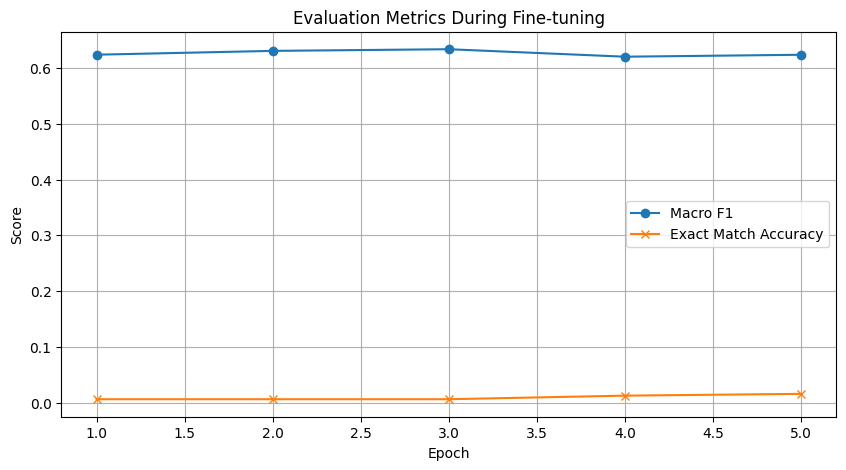

In [25]:
# Extract training and evaluation logs
log_df = pd.DataFrame(trainer.state.log_history)

# Filter only the entries that contain evaluation results
eval_logs = log_df[log_df["eval_loss"].notna()]

# Plot Macro F1 and Exact Match Accuracy
plt.figure(figsize=(10, 5))
plt.plot(eval_logs["epoch"], eval_logs["eval_macro_f1"], label="Macro F1", marker='o')
plt.plot(eval_logs["epoch"], eval_logs["eval_exact_match_accuracy"], label="Exact Match Accuracy", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics During Fine-tuning")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
export_dir = "./camembert_multilabel_model"
CamemBERT.save_pretrained(export_dir)
tokenizer_CamemBERT.save_pretrained(export_dir)

shutil.make_archive("camembert_multilabel_model", 'zip', export_dir)

Configuration saved in ./camembert_multilabel_model/config.json
Model weights saved in ./camembert_multilabel_model/pytorch_model.bin
tokenizer config file saved in ./camembert_multilabel_model/tokenizer_config.json
Special tokens file saved in ./camembert_multilabel_model/special_tokens_map.json


'/content/camembert_multilabel_model.zip'

Conclusion – First Fine-tuning Attempt
The initial fine-tuning of CamemBERT on the multi-label QCM dataset led to a significant improvement in partial prediction quality, as reflected by the macro F1-score, which stabilized around 62–63% across all five epochs.

However, the exact match accuracy remains very low—starting at 0.64% and reaching only 1.6% by epoch 5. This suggests that while the model is often partially correct (capturing at least one good answer), it struggles to predict the full correct set of answers exactly.

This gap highlights the complexity of the task and suggests the need to condition the model more precisely on the structure of each question.

💡 Next Step: Conditioning on Question Type
To further guide the model, the next improvement will consist of explicitly including the question type (simple or multiple) as part of the input prompt. This additional context is expected to help the model:

Focus on predicting a single label when only one correct answer is expected,

Or broaden its prediction when the question allows multiple answers.

This strategy may contribute to improving both exact match accuracy and overall F1-score.

In [29]:
# Load tokenizer
tokenizer_CamemBERT = AutoTokenizer.from_pretrained("camembert-base")

# Convert correct answers into binary vector
def label_to_vector(correct_answers):
    vec = [0] * 5
    for ans in correct_answers:
        ans = ans.lower()
        if ans in ['a', 'b', 'c', 'd', 'e']:
            idx = ord(ans) - ord('a')
            vec[idx] = 1
    return vec

# Add 'type' column to your dataframe if missing
for df in [df_train, df_dev]:
    df["type"] = df["correct_answers"].apply(lambda x: "simple" if len(x) == 1 else "multiple")

# Custom dataset class
class QADataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.encodings = []
        self.labels = []
        for _, row in dataframe.iterrows():
            try:
                q = row["question"]
                answers = row["answers"]
                corrects = row["correct_answers"]
                q_type = row["type"]
                label_vec = label_to_vector(corrects)
                merged = " ".join([f"{k.upper()}: {v}" for k, v in sorted(answers.items())])
                full_input = f"Type: {q_type}. Question: {q} Answers: {merged}"
                encoding = tokenizer(full_input, truncation=True, padding='max_length', max_length=256)
                self.encodings.append(encoding)
                self.labels.append(label_vec)
            except Exception as e:
                continue

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenize_batch().items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def tokenize_batch(self):
        return tokenizer_CamemBERT.pad(self.encodings, return_tensors="pt")

# Create datasets
train_dataset_with_type = QADataset(df_train, tokenizer_CamemBERT)
dev_dataset_with_type = QADataset(df_dev, tokenizer_CamemBERT)

loading configuration file https://huggingface.co/camembert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f459e43c5ebb871abbf9209195563bff6a11547fd9532047739667c394833221.e23d229c54bcc6f67d337b8b2dd111b0e3dc01fa854bfecd3efdeb8c955749e6
Model config CamembertConfig {
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}

loading file https://hugg

In [30]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True
)

PyTorch: setting up devices


In [31]:
# Initialize Trainer with new dataset
trainer = Trainer(
    model=CamemBERT,
    args=training_args,
    train_dataset=train_dataset_with_type,
    eval_dataset=dev_dataset_with_type,
    compute_metrics=compute_metrics
)

In [32]:
# Fine-tune the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2171
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 816
<ipython-input-29-1393b28b7b46>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.tokenize_batch().items()}


Epoch,Training Loss,Validation Loss,Exact Match Accuracy,Macro F1
1,No log,0.579788,0.009615,0.638441
2,0.618600,0.581451,0.012821,0.637217
3,0.618600,0.584059,0.016026,0.615753


***** Running Evaluation *****
  Num examples = 312
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-272
Configuration saved in ./results/checkpoint-272/config.json
Model weights saved in ./results/checkpoint-272/pytorch_model.bin
<ipython-input-29-1393b28b7b46>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.tokenize_batch().items()}
***** Running Evaluation *****
  Num examples = 312
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-544
Configuration saved in ./results/checkpoint-544/config.json
Model weights saved in ./results/checkpoint-544/pytorch_model.bin
<ipython-input-29-1393b28b7b46>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True

TrainOutput(global_step=816, training_loss=0.6116164712344899, metrics={'train_runtime': 1660.8041, 'train_samples_per_second': 3.922, 'train_steps_per_second': 0.491, 'total_flos': 856844230934016.0, 'train_loss': 0.6116164712344899, 'epoch': 3.0})

In [33]:
export_dir = "./camembert_multilabel_model_with_type"
CamemBERT.save_pretrained(export_dir)
tokenizer_CamemBERT.save_pretrained(export_dir)

shutil.make_archive("camembert_multilabel_model_with_type", 'zip', export_dir)

Configuration saved in ./camembert_multilabel_model_with_type/config.json
Model weights saved in ./camembert_multilabel_model_with_type/pytorch_model.bin
tokenizer config file saved in ./camembert_multilabel_model_with_type/tokenizer_config.json
Special tokens file saved in ./camembert_multilabel_model_with_type/special_tokens_map.json


'/content/camembert_multilabel_model_with_type.zip'

# **Fine-Tuning with Question Type + Deployment Perspective**
In this second fine-tuning attempt, I included the question type ("simple" or "multiple") directly in the input prompt. This additional context helped the model better interpret the task structure.

While the exact match accuracy showed a modest improvement (from 0.64% to 1.60%), the macro F1-score remained stable around 63%, confirming that the model consistently captures partial correctness.

These results suggest that embedding structural information such as question type helps the model generate more informed and context-aware predictions, especially when distinguishing between single-answer and multi-answer QCMs — a key aspect for real-world deployment.

⚠️ **Practical Note:** Using the Model in a Web Application
In a real-time web application where users freely enter their questions, the system does not know in advance whether the question is "simple" or "multiple". Since the model was trained using this information in the input, two robust strategies can be applied at inference time:

*   Default to "Type: multiple" for all questions
This generic setting assumes that multiple answers may be correct. After prediction, the system can infer the actual type by checking how many answers were selected (e.g., one → likely "simple", more → "multiple").
*   Run both type variants and compare
The model is queried twice, once with "Type: simple" and once with "Type: multiple". The system then selects the most consistent prediction, possibly based on confidence levels or number of predicted labels.





# **Perspectives and Future Improvements**
While this project focused on supervised fine-tuning of CamemBERT for multi-label QCM classification, two particularly promising strategies could be explored to further improve the model’s performance and generalization:

*   Retrieval-Augmented Generation (RAG):

  RAG models enhance standard language models by retrieving relevant documents at inference time. This could significantly boost exact match accuracy, especially for domain-specific questions (e.g., in pharmacy), by grounding predictions in external factual knowledge rather than relying solely on pretrained weights. It allows the model to be more precise and complete when the correct answer requires background information.

*   Data Augmentation:

  Techniques such as paraphrasing questions, shuffling answer orders, or generating synthetic QCMs can increase the diversity and robustness of the training set. This can lead to better generalization, particularly for less frequent answer patterns, and is likely to improve the macro F1-score by helping the model perform more consistently across all classes and reduce bias toward dominant answer patterns.








These approaches complement the current architecture and would strengthen both the model's strict correctness (exact match) and overall label-wise balance (macro F1), especially in real-world and low-resource scenarios.